In [1]:
import numpy as np
import sys
import numpy as np
import gym
from gym import wrappers
import frozen_lake as fl
import frozen_lake_rewards as fl_r
import frozen_lake_rewards_v2 as fl_rv2
import time
import pandas as pd
import matplotlib
import plotting
from gym.envs.toy_text import discrete

from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')


if "../" not in sys.path:
  sys.path.append("../")

In [2]:
def value_iteration(env, theta=0.00001, discount_factor=1.0):
    
    def one_step_lookahead(state, V):
        A = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    # Create a deterministic policy using the optimal value function
    def get_policy(env, V):
        policy = np.zeros([env.observation_space.n, env.action_space.n])
        for s in range(env.observation_space.n):
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, V)
            best_action = np.argmax(A)
            # Always take the best action
            policy[s, best_action] = 1.0

        return policy
    
    def run_episode(env, policy, gamma, render = False):
        obs = env.reset()
        total_reward = 0
        step_idx = 0
        while True:
            if render:
                env.render()
            obs, reward, done , _ = env.step(int(np.argmax(policy[obs])))
            #total_reward += (gamma ** step_idx * reward)
            total_reward += reward
            step_idx += 1
            if done:
                break
        return total_reward


    def evaluate_policy(env, policy, gamma,  n = 100):
        scores = [
                run_episode(env, policy, gamma = gamma, render = False)
                for _ in range(n)]
        return np.mean(scores)

    V = np.zeros(env.observation_space.n)
    i = 0
    
    value_differences = []
    iteration_rewards = []
    iteration_time_differences = []
    run_time_elapsed = []
    
    run_start_time = time.time()
    
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        i+=1
        iteration_start_time = time.time()
        
        for s in range(env.observation_space.n):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value  
        
        
        iteration_end_time = time.time()
        iteration_time_taken = (iteration_end_time - iteration_start_time)

        value_differences.append(delta)
        iteration_time_differences.append(iteration_time_taken)
        run_time_elapsed.append(iteration_end_time - run_start_time)
        # Check if we can stop 
        print(i)
        
        if i%10 == 1:
            policy = get_policy(env, V)
            current_policy_score = evaluate_policy(env, policy, discount_factor,  n = 100)
            iteration_rewards.append([i,current_policy_score])
            #print(i)
        
        if delta < theta:
            print(i)
            break
        
        policy = get_policy(env, V)
    

    
    return policy, V, value_differences, iteration_time_differences, run_time_elapsed, iteration_rewards

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
254
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]


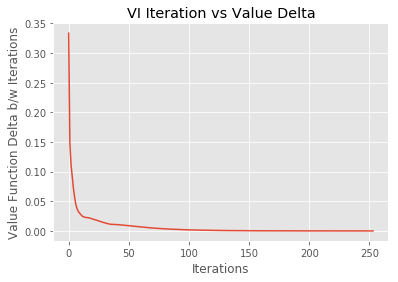

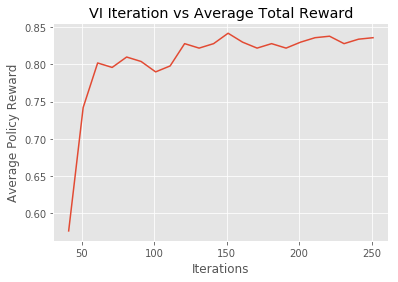

In [3]:
g = 1.0
env = fl.FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=True)
policy, v, value_differences, iteration_time_differences, run_time_elapsed, iteration_rewards = value_iteration(env, discount_factor = g)


print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.nrow*env.ncol))
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.ncol * env.nrow))
print("")

print("Iterations and Reward until Convergence")
print(iteration_rewards[-1])

plt.plot(value_differences)
plt.xlabel('Iterations')
plt.ylabel('Value Function Delta b/w Iterations')
plt.title('VI Iteration vs Value Delta')
plt.show()

iteration_rewards = pd.DataFrame(iteration_rewards, columns = ['Iteration','Average Total Policy Reward'])
iteration_rewards.set_index('Iteration')
plt.xlabel('Iterations')
plt.ylabel('Average Policy Reward')
plt.title('VI Iteration vs Average Total Reward')
plt.plot(iteration_rewards['Iteration'],iteration_rewards['Average Total Policy Reward'].rolling(5).mean())
plt.show()

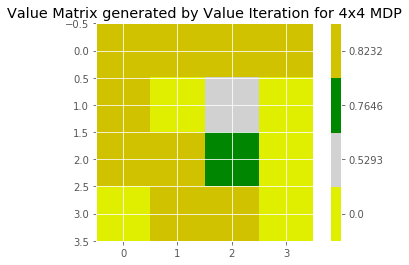

In [83]:
import matplotlib.pyplot as plt
import matplotlib.colors

a = v.reshape(4,4)
ca = v.reshape(4,4)

u, ind = np.unique(a, return_inverse=True)
b = ind.reshape((a.shape))

colors = a[a[:,0].argsort()][:,1:]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(np.arange(len(a)+1)-0.5, len(a))

plt.imshow(b, cmap=cmap, norm=norm)

cb = plt.colorbar(ticks=np.arange(len(a)))
cb.ax.set_yticklabels(np.unique(a).round(4))

plt.title('Value Matrix generated by Value Iteration for 4x4 MDP')
plt.show()

1199
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 0 0 0 0 2 3 3 3 3 3 0 0 2 3 3 3 3 3 0 0 2 3 3 3 3 3 0 0 2 3 3
 3 3 3 0 0 2 3 3 3 0 0 0 1 0 0 2 3 3 3 0 1 0 0 2 3 3 3 0 1 0 0 2 3 3 3 0 1
 0 0 2 3 3 3 0 1 0 0 2 3 0 3 0 0 2 1 3 3 3 3 0 0 2 1 3 3 3 3 0 0 2 1 3 3 3
 3 0 0 2 1 3 3 3 3 0 0 2 1 3 3 0 0 0 1 3 0 0 2 0 0 0 1 3 0 0 2 0 0 0 1 3 0
 0 2 0 0 0 1 3 0 0 2 0 0 0 1 3 0 0 2 0 0 1 0 0 0 0 2 0 0 1 0 0 0 0 2 0 0 1
 0 0 0 0 2 0 0 1 0 0 0 0 2 0 0 1 0 0 0 0 2 3 1 0 0 1 1 0 0 2 1 0 0 1 1 0 0
 2 1 0 0 1 1 0 0 2 1 0 0 1 1 0 0 2 1 0 0 1 1 0 0 0 2 1 1 1 1 1 0 0 2 1 1 1
 1 1 0 0 2 1 1 1 1 1 0 0 2 1 1 1 1 1 0 0 2 1 1 1 1 1 1 1 1 1 3 3 1 1 1 1 1
 1 3 2 1 1 1 1 1 1 3 2 1 1 1 1 1 1 3 2 1 1 1 1 1 1 3 3 3 3 3 3 3 0 0 2 3 2
 2 2 3 0 0 2 3 2 2 2 3 0 0 2 3 2 2 2 2 0 0 2 3 2 1 1 1 0 0 2 3 2 3 3 3 0 1
 0 0 2 2 3 3 0 1 0 0 2 2 3 3 0 1 0 0 2 2 

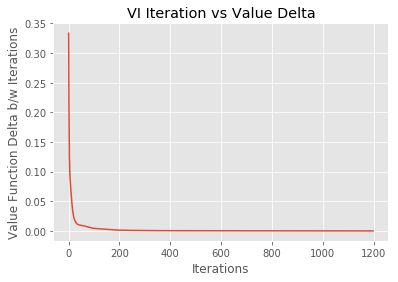

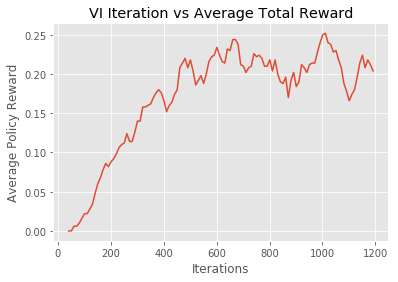

In [92]:
g = 1.0
env = fl.FrozenLakeEnv(desc=None, map_name="22x40",is_slippery=True)
policy, v, value_differences, iteration_time_differences, run_time_elapsed, iteration_rewards = value_iteration(env, discount_factor = g)


print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.nrow*env.ncol))
print("")

print()
print(iteration_rewards[-1])

plt.plot(value_differences)
plt.xlabel('Iterations')
plt.ylabel('Value Function Delta b/w Iterations')
plt.title('VI Iteration vs Value Delta')
plt.show()

iteration_rewards = pd.DataFrame(iteration_rewards, columns = ['Iteration','Average Total Policy Reward'])
iteration_rewards.set_index('Iteration')
plt.xlabel('Iterations')
plt.ylabel('Average Policy Reward')
plt.title('VI Iteration vs Average Total Reward')
plt.plot(iteration_rewards['Iteration'],iteration_rewards['Average Total Policy Reward'].rolling(5).mean())
plt.show()

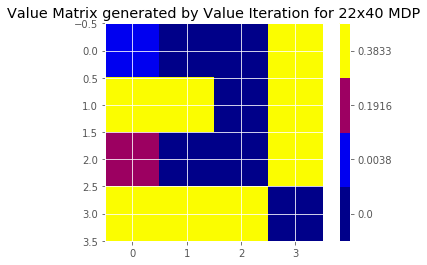

In [93]:
import matplotlib.pyplot as plt
import matplotlib.colors

a = v[864:880].reshape(4,4)
ca = v[864:880].reshape(4,4)

u, ind = np.unique(a, return_inverse=True)
b = ind.reshape((a.shape))

colors = a[a[:,0].argsort()][:,1:]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(np.arange(len(a)+1)-0.5, len(a))
plt.imshow(b, cmap=cmap, norm=norm)

cb = plt.colorbar(ticks=np.arange(len(a)))
cb.ax.set_yticklabels(np.unique(a).round(4))

plt.title('Value Matrix generated by Value Iteration for 22x40 MDP')

plt.show()

# Impact of Gamma

5
Gamma: 0.1
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 1 2 3 0 0 0 0 1 1 0 0 0 2 1 0]

[1, 0.0]


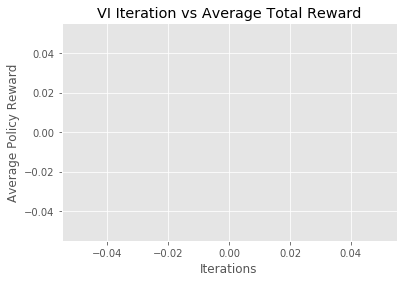

7
Gamma: 0.3
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[1 3 2 3 0 0 0 0 3 1 0 0 0 2 1 0]

[1, 0.0]


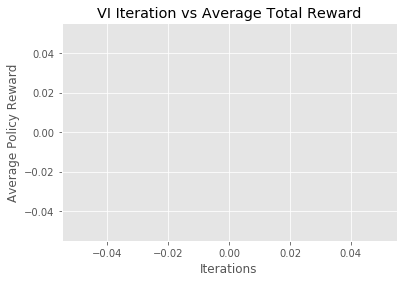

11
Gamma: 0.5
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[1 3 2 3 0 0 0 0 3 1 0 0 0 2 1 0]

[11, 0.5]


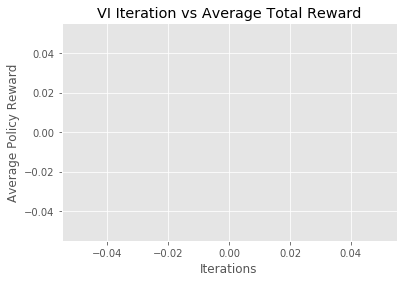

18
Gamma: 0.7
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[1 3 2 3 0 0 0 0 3 1 0 0 0 2 1 0]

[11, 0.43]


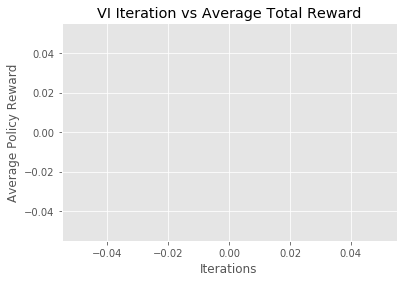

48
Gamma: 0.9
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]

[41, 0.75]


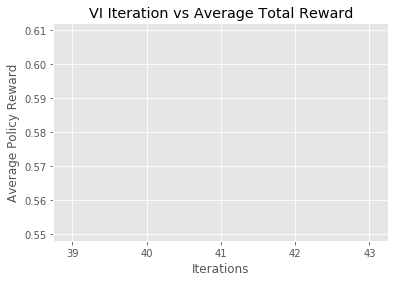

77
Gamma: 0.95
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]

[71, 0.82]


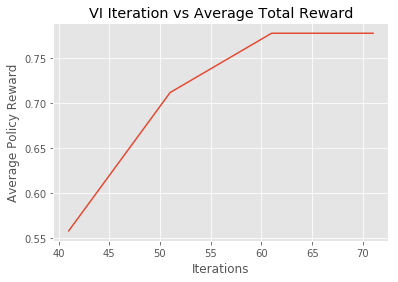

137
Gamma: 0.98
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]

[131, 0.81]


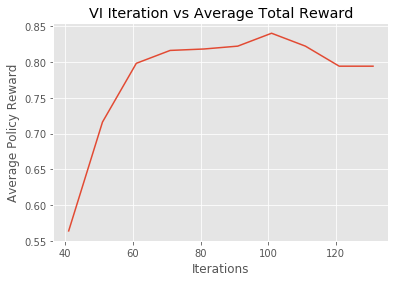

254
Gamma: 1.0
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]

[251, 0.87]


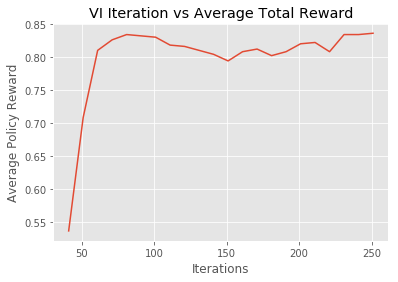

In [94]:
gamma_list = [0.1,0.3,0.5,0.7,0.9,0.95,0.98,1.0]
value_differences_list = []
iteration_rewards_list = []
run_time_list = []

for g in gamma_list:
    env = fl.FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=True)
    policy, v, value_differences, iteration_time_differences, run_time_elapsed, iteration_rewards = value_iteration(env, discount_factor = g)
    run_time_list.append(run_time_elapsed)
    iteration_rewards_list.append(iteration_rewards)
    value_differences_list.append(value_differences)
    
    print('Gamma: ' + str(g))
    print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
    print(np.reshape(np.argmax(policy, axis=1), env.nrow*env.ncol))
    print("")
    
    print(iteration_rewards[-1])
    
    iteration_rewards = pd.DataFrame(iteration_rewards, columns = ['Iteration','Average Total Policy Reward'])
    iteration_rewards.set_index('Iteration')
    plt.xlabel('Iterations')
    plt.ylabel('Average Policy Reward')
    plt.title('VI Iteration vs Average Total Reward')
    plt.plot(iteration_rewards['Iteration'],iteration_rewards['Average Total Policy Reward'].rolling(5).mean())
    plt.show()

5
Gamma: 0.1
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

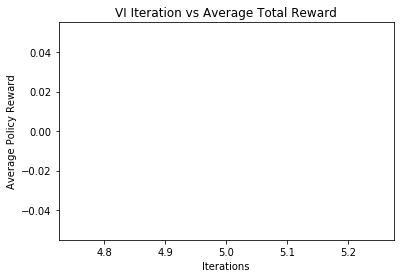

8
Gamma: 0.3
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

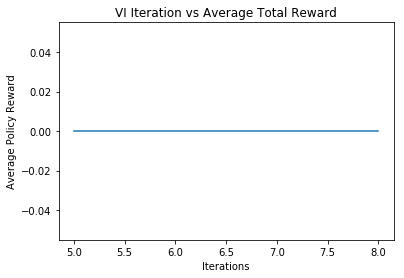

11
Gamma: 0.5
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

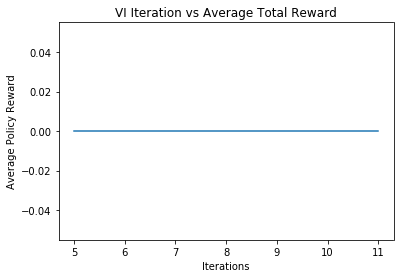

18
Gamma: 0.7
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 3 2 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 2 3 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

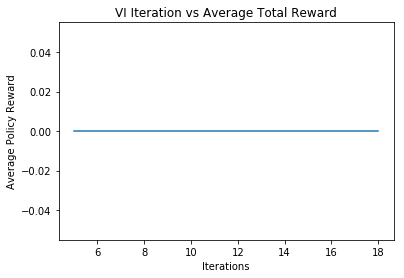

43
Gamma: 0.9
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2
 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 3 2 2 2 1 1 1 2 3 2 1 1 1 1 1
 1 3 2 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 0 0 2 3 2 1 1 1 0 0 2 3 1
 1 1 1 0 0 2 3 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 2 1 1 1 1 1
 0 0 2 1 1 1 1 1 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 3 2 1 3 0 0 2 1 3 2 1
 3 0 0 2 1 3 1 0 3 0 0 2 1 3 3 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 2 0 0 0 1 3 0
 0 2 0 0 0 1 3 0 0 2 0 0 0 1 3 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1
 0 0 0 0 2 0 0 1 0 0 0 0 2 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 2 1 0 0 1 1 0 0 2 1 0 0 1 1 0 0 2 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2
 1 1 0 0 2 1 1 2 1 1 0 0 2 1 1 1 1 1 0 0 2 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 2
 2 3 2 2 2 1 1 2 2 3 2 2 1 1 1 2 2 3 2 1 1 1 1 1 1 3 1 1 1 1 0 0 0 0 0 0 1
 1 2 2 0 0 2 3 2 2 2 2 0 0 2 3 2 1 1 2 0 0 2 3 2 1 1 1 0 0 2 3 2 1 0 0 0 0
 0 0 1 2 2 2 2 1 0 0 2 2 2 2 1 1

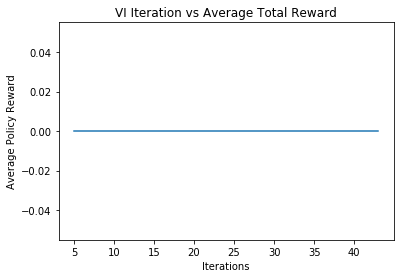

75
Gamma: 0.95
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 1 2
 2 2 2 1 2 2 3 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 3 2 1 1 1 1 0
 0 3 1 1 1 1 1 2 0 0 2 3 2 2 2 2 0 0 2 3 2 2 2 2 0 0 2 3 2 1 1 1 0 0 2 3 2
 1 1 0 0 0 2 3 1 1 1 2 2 1 0 0 2 2 2 2 3 1 0 0 2 2 1 3 3 1 0 0 2 1 1 1 3 1
 0 0 2 1 1 0 3 1 0 0 2 1 1 3 0 0 2 1 3 2 1 3 0 0 2 1 3 2 0 3 0 0 2 1 3 1 0
 3 0 0 2 1 3 1 0 3 0 0 2 1 3 3 0 0 0 1 3 0 0 2 0 0 0 1 3 0 0 2 0 0 0 1 3 0
 0 2 0 0 0 1 3 0 0 2 0 0 0 1 3 0 0 2 0 0 1 0 0 0 0 2 0 0 1 0 0 0 0 2 0 0 1
 0 0 0 0 2 0 0 1 0 0 0 0 2 0 0 1 0 0 0 0 2 3 1 0 0 1 1 0 0 2 1 0 0 1 1 0 0
 2 1 0 0 1 1 0 0 2 1 0 0 1 1 0 0 2 1 0 0 1 1 0 0 0 2 1 1 2 1 1 0 0 2 1 1 1
 1 1 0 0 2 1 1 1 1 1 0 0 2 1 1 1 1 1 0 0 2 1 1 1 1 1 1 1 2 2 3 2 2 2 1 1 2
 2 3 2 2 1 1 1 2 2 3 2 2 1 1 1 2 2 3 2 2 1 1 1 1 1 3 1 1 1 1 1 2 0 0 2 3 2
 2 2 2 0 0 2 3 2 2 2 2 0 0 2 3 2 1 2 2 0 0 2 3 2 1 1 1 0 0 2 3 2 1 1 2 2 1
 0 0 2 2 2 2 2 1 0 0 2 2 2 2 2 

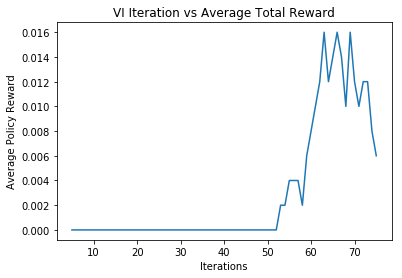

140
Gamma: 0.98
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 1
 2 2 2 3 2 3 3 2 2 2 2 2 3 3 3 2 2 2 2 2 3 3 3 2 2 2 2 2 3 3 3 2 2 2 1 1 0
 0 3 1 1 1 1 3 3 0 0 2 3 2 2 3 3 0 0 2 3 2 2 3 3 0 0 2 3 2 2 2 3 0 0 2 3 2
 1 1 0 0 0 2 3 2 1 2 3 3 1 0 0 2 3 3 3 3 1 0 0 2 2 2 3 3 1 0 0 2 2 0 3 3 1
 0 0 2 1 0 0 0 1 0 0 2 1 0 3 0 0 2 1 3 3 2 3 0 0 2 1 3 2 0 3 0 0 2 1 3 1 0
 3 0 0 2 1 3 1 0 3 0 0 2 1 3 3 0 0 0 1 3 0 0 2 0 0 0 1 3 0 0 2 0 0 0 1 3 0
 0 2 0 0 0 1 3 0 0 2 0 0 0 1 3 0 0 2 0 0 1 0 0 0 0 2 0 0 1 0 0 0 0 2 0 0 1
 0 0 0 0 2 0 0 1 0 0 0 0 2 0 0 1 0 0 0 0 2 3 1 0 0 1 1 0 0 2 1 0 0 1 1 0 0
 2 1 0 0 1 1 0 0 2 1 0 0 1 1 0 0 2 1 0 0 1 1 0 0 0 2 1 1 1 1 1 0 0 2 1 1 1
 1 1 0 0 2 1 1 1 1 1 0 0 2 1 1 1 1 1 0 0 2 1 1 1 1 1 1 1 2 3 3 2 2 1 1 1 2
 3 3 2 2 1 1 1 2 3 3 2 2 1 1 1 1 2 3 2 2 1 1 1 1 0 3 3 1 1 1 3 3 0 0 2 3 2
 2 2 2 0 0 2 3 2 2 2 2 0 0 2 3 2 2 2 2 0 0 2 3 2 1 1 1 0 0 2 3 2 1 3 3 3 1
 0 0 2 2 2 3 3 1 0 0 2 2 2 2 0

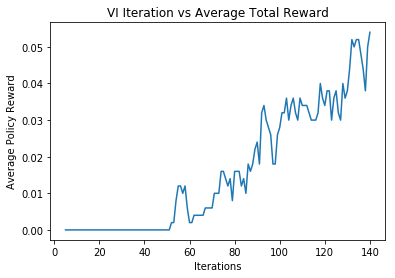

1199
Gamma: 1.0
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 0 0 0 0 2 3 3 3 3 3 0 0 2 3 3 3 3 3 0 0 2 3 3 3 3 3 0 0 2 3 3
 3 3 3 0 0 2 3 3 3 0 0 0 1 0 0 2 3 3 3 0 1 0 0 2 3 3 3 0 1 0 0 2 3 3 3 0 1
 0 0 2 3 3 3 0 1 0 0 2 3 0 3 0 0 2 1 3 3 3 3 0 0 2 1 3 3 3 3 0 0 2 1 3 3 3
 3 0 0 2 1 3 3 3 3 0 0 2 1 3 3 0 0 0 1 3 0 0 2 0 0 0 1 3 0 0 2 0 0 0 1 3 0
 0 2 0 0 0 1 3 0 0 2 0 0 0 1 3 0 0 2 0 0 1 0 0 0 0 2 0 0 1 0 0 0 0 2 0 0 1
 0 0 0 0 2 0 0 1 0 0 0 0 2 0 0 1 0 0 0 0 2 3 1 0 0 1 1 0 0 2 1 0 0 1 1 0 0
 2 1 0 0 1 1 0 0 2 1 0 0 1 1 0 0 2 1 0 0 1 1 0 0 0 2 1 1 1 1 1 0 0 2 1 1 1
 1 1 0 0 2 1 1 1 1 1 0 0 2 1 1 1 1 1 0 0 2 1 1 1 1 1 1 1 1 1 3 3 1 1 1 1 1
 1 3 2 1 1 1 1 1 1 3 2 1 1 1 1 1 1 3 2 1 1 1 1 1 1 3 3 3 3 3 3 3 0 0 2 3 2
 2 2 3 0 0 2 3 2 2 2 3 0 0 2 3 2 2 2 2 0 0 2 3 2 1 1 1 0 0 2 3 2 3 3 3 0 1
 0 0 2 2 3 3 0 1 0 0 2 2 3 3 0

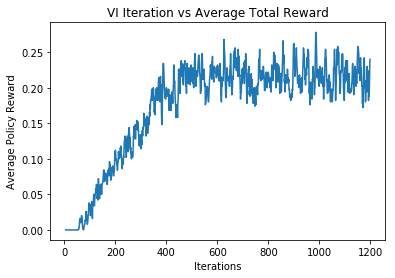

In [35]:
gamma_list = [0.1,0.3,0.5,0.7,0.9,0.95,0.98,1.0]
value_differences_list = []
iteration_rewards_list = []
run_time_list = []

for g in gamma_list:
    env = fl.FrozenLakeEnv(desc=None, map_name="22x40",is_slippery=True)
    policy, v, value_differences, iteration_time_differences, run_time_elapsed, iteration_rewards = value_iteration(env, discount_factor = g)
    run_time_list.append(run_time_elapsed)
    iteration_rewards_list.append(iteration_rewards)
    value_differences_list.append(value_differences)
    
    print(iteration_rewards[-1])
    
    iteration_rewards = pd.DataFrame(iteration_rewards, columns = ['Iteration','Average Total Policy Reward'])
    iteration_rewards.set_index('Iteration')
    plt.xlabel('Iterations')
    plt.ylabel('Average Policy Reward')
    plt.title('VI Iteration vs Average Total Reward')
    plt.plot(iteration_rewards['Iteration'],iteration_rewards['Average Total Policy Reward'].rolling(5).mean())
    plt.show()


# Policy Iteration

In [20]:
"""
Solving FrozenLake8x8 environment using Policy iteration.
Author : Moustafa Alzantot (malzantot@ucla.edu)
"""
import numpy as np
import gym
from gym import wrappers


def run_episode(env, policy, gamma = 1.0, render = False):
    """ Runs an episode and return the total reward """
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int((policy[obs])))
        #total_reward += (gamma ** step_idx * reward)
        total_reward += reward
        step_idx += 1
        if done:
            break
    return total_reward


def evaluate_policy(env, policy, gamma = 1.0, n = 500):
    scores = [run_episode(env, policy, gamma, False) for _ in range(n)]
    return np.mean(scores)

def extract_policy(v, gamma = 1.0):
    """ Extract the policy given a value-function """
    policy = np.zeros(env.observation_space.n)
    for s in range(env.observation_space.n):
        q_sa = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            q_sa[a] = sum([p * (r + gamma * v[s_]) for p, s_, r, _ in  env.P[s][a]])
        policy[s] = np.argmax(q_sa)
    return policy

def compute_policy_v(env, policy, gamma=1.0):
    """ Iteratively evaluate the value-function under policy.
    Alternatively, we could formulate a set of linear equations in iterms of v[s] 
    and solve them to find the value function.
    """
    v = np.zeros(env.observation_space.n)
    eps = 1e-5
    while True:
        prev_v = np.copy(v)
        for s in range(env.observation_space.n):
            policy_a = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, _ in env.P[s][policy_a]])
        if (np.sum((np.fabs(prev_v - v))) <= eps):
            # value converged
            break
    return v

def policy_iteration(env, gamma = 1.0):
    np.random.seed(10)
    """ Policy-Iteration algorithm """
    policy = np.random.choice(env.action_space.n, size=(env.observation_space.n))  # initialize a random policy
    max_iterations = 200000
    
    policy_differences = []
    iteration_rewards = []
    iteration_time_differences = []
    run_time_elapsed =[]
    
    run_start_time = time.time()
    
    
    for i in range(max_iterations):
        iteration_start_time = time.time()
        old_policy_v = compute_policy_v(env, policy, gamma)
        new_policy = extract_policy(old_policy_v, gamma)
        old_scores = evaluate_policy(env, old_policy_v, gamma)
        new_scores = evaluate_policy(env, new_policy, gamma)
                
        iteration_end_time = time.time()
        iteration_time_taken = (iteration_end_time - iteration_start_time)
        
        #print(np.sum(np.abs(new_policy - policy)))

        policy_differences.append(np.sum(np.abs(new_policy - policy)))
        iteration_time_differences.append(iteration_time_taken)
        run_time_elapsed.append(iteration_end_time - run_start_time)
        
        iteration_rewards.append([i,new_scores])
        #print(current_policy_score)
        print(i)
        
        if (np.all(policy == new_policy)):
            print ('Policy-Iteration converged at step %d.' %(i+1))
            break
        policy = new_policy
        
    return policy, policy_differences, iteration_rewards, iteration_time_differences, run_time_elapsed

# Impact of Gamma

Gamma: 0.1
0
1
2
3
4
Policy-Iteration converged at step 5.
Average scores =  0.468


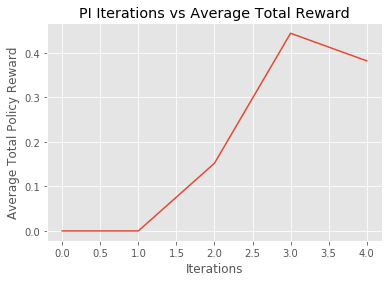

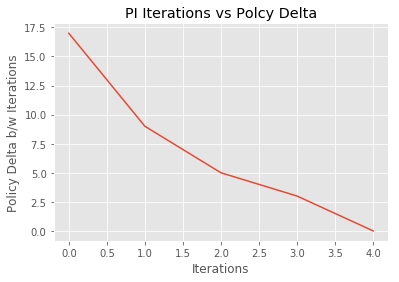

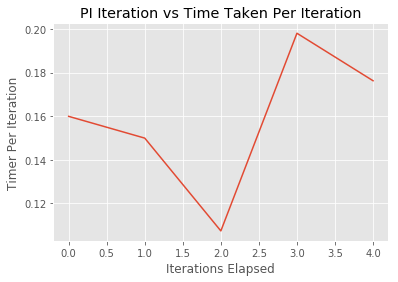

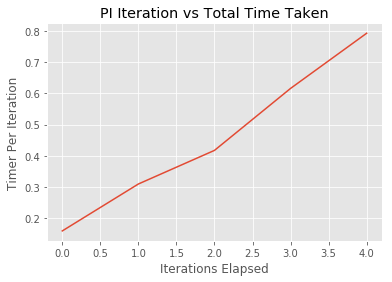

Gamma: 0.3
0
1
2
3
4
Policy-Iteration converged at step 5.
Average scores =  0.448


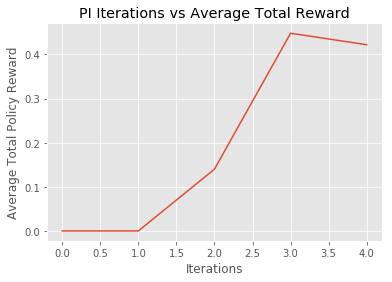

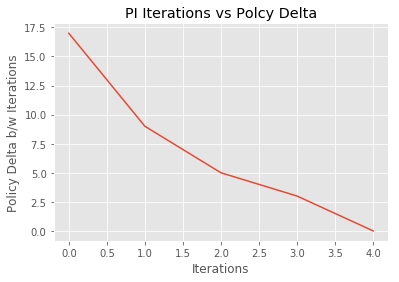

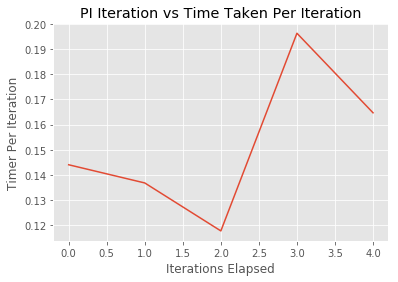

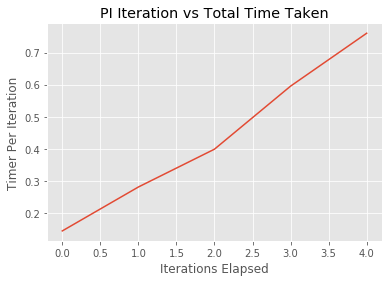

Gamma: 0.5
0
1
2
3
4
Policy-Iteration converged at step 5.
Average scores =  0.44


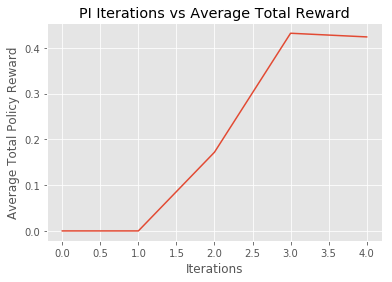

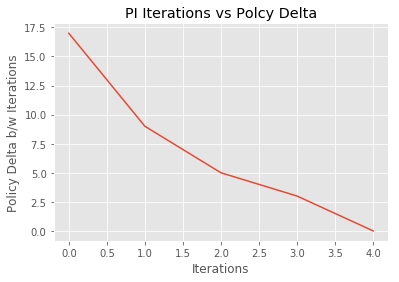

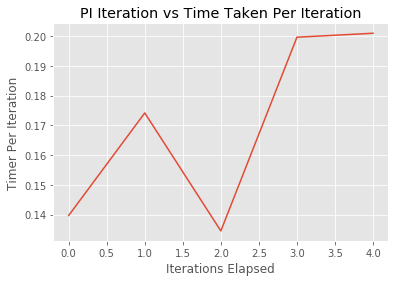

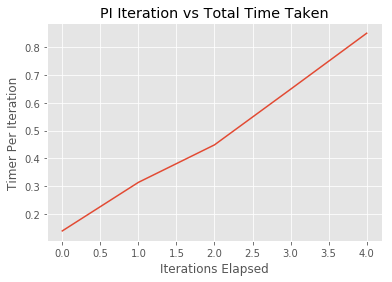

Gamma: 0.7
0
1
2
3
4
Policy-Iteration converged at step 5.
Average scores =  0.442


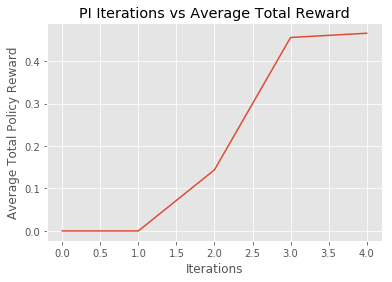

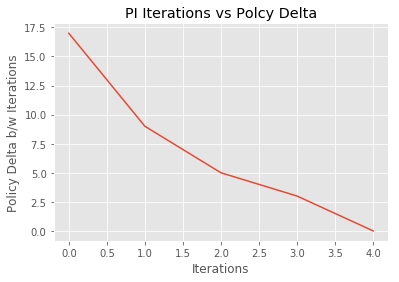

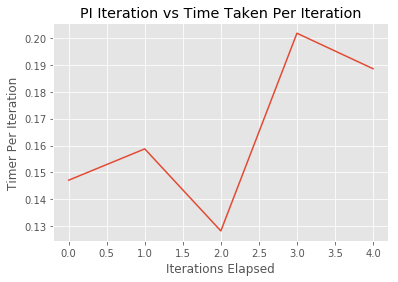

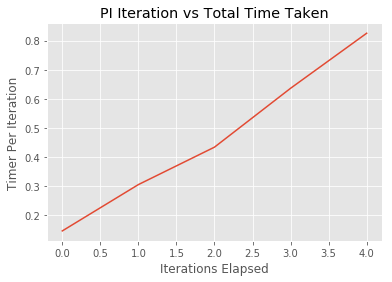

Gamma: 0.9
0
1
2
3
4
5
Policy-Iteration converged at step 6.
Average scores =  0.778


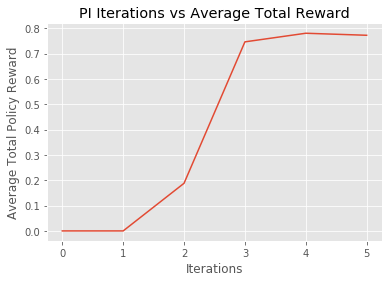

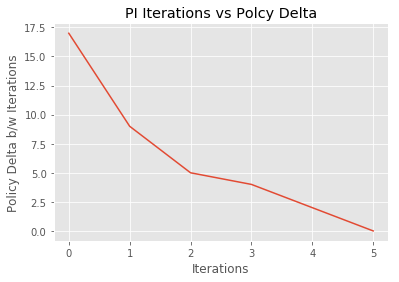

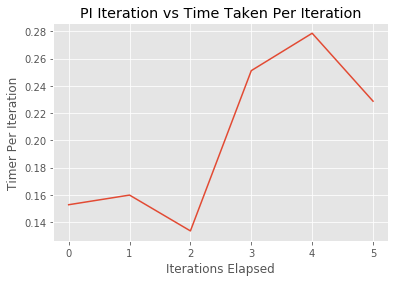

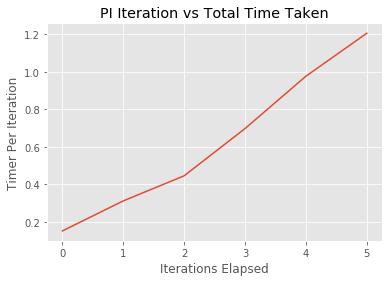

Gamma: 0.95
0
1
2
3
4
5
Policy-Iteration converged at step 6.
Average scores =  0.778


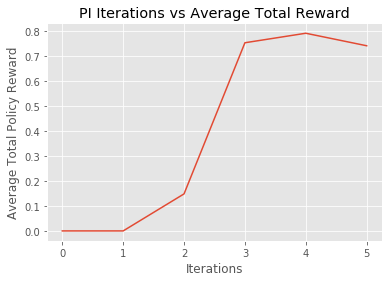

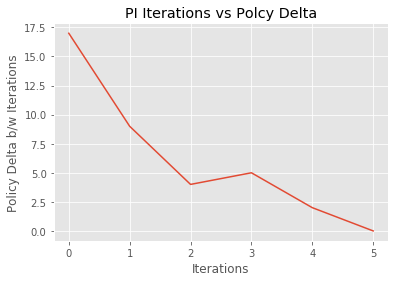

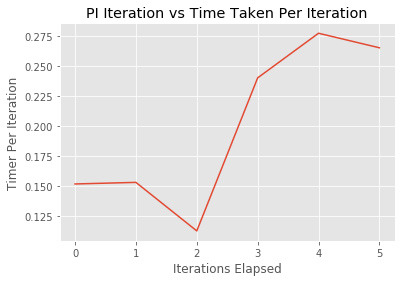

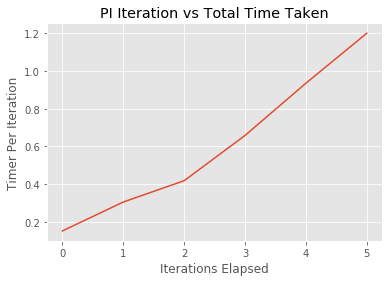

Gamma: 1.0
0
1
2
3
4
5
6
Policy-Iteration converged at step 7.
Average scores =  0.85


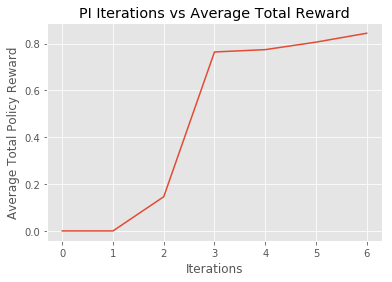

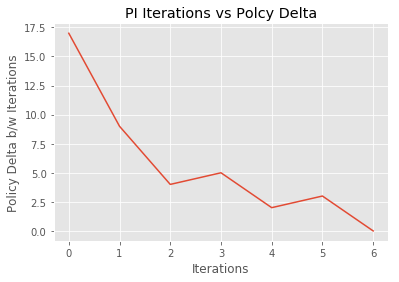

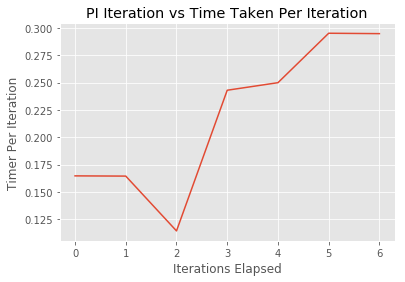

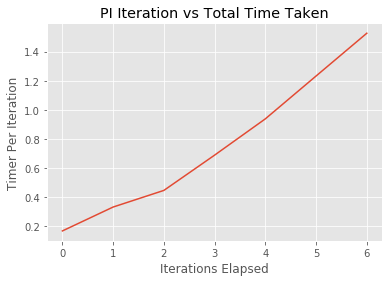

In [111]:
gamma_list = [0.1,0.3,0.5,0.7,0.9,0.95,1.0]
for g in gamma_list:
    print('Gamma: ' + str(g))
    env = fl.FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=True)
    optimal_policy, policy_differences, iteration_rewards, iteration_time_differences, run_time_elapsed = policy_iteration(env, gamma = g)
    scores = evaluate_policy(env, optimal_policy, gamma = g)
    print('Average scores = ', np.mean(scores))

    iteration_rewards = pd.DataFrame(iteration_rewards, columns = ['Iteration','Average Total Policy Reward'])
    iteration_rewards.set_index('Iteration')
    plt.xlabel('Iterations')
    plt.ylabel('Average Total Policy Reward')
    plt.title('PI Iterations vs Average Total Reward')
    plt.plot(iteration_rewards['Iteration'],iteration_rewards['Average Total Policy Reward'])
    plt.show()

    plt.plot(policy_differences)
    plt.xlabel('Iterations')
    plt.ylabel('Policy Delta b/w Iterations')
    plt.title('PI Iterations vs Polcy Delta')
    plt.show()

    plt.plot(pd.DataFrame(iteration_time_differences))
    plt.xlabel('Iterations Elapsed')
    plt.ylabel('Timer Per Iteration')
    plt.title('PI Iteration vs Time Taken Per Iteration')
    plt.show()

    plt.plot(run_time_elapsed)
    plt.xlabel('Iterations Elapsed')
    plt.ylabel('Timer Per Iteration')
    plt.title('PI Iteration vs Total Time Taken')
    plt.show()

Gamma: 0.1
0
1
2
3
Policy-Iteration converged at step 4.
Average scores =  0.0


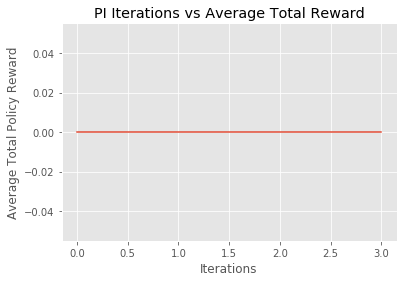

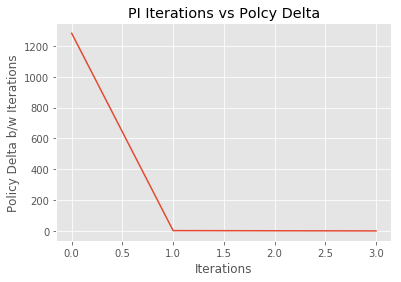

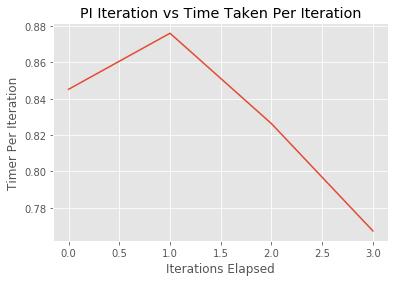

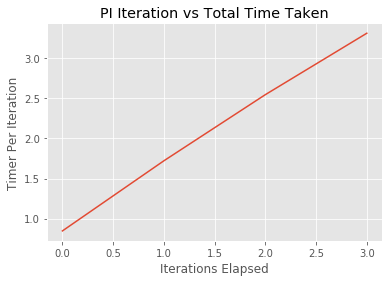

Gamma: 0.3
0
1
2
3
Policy-Iteration converged at step 4.
Average scores =  0.0


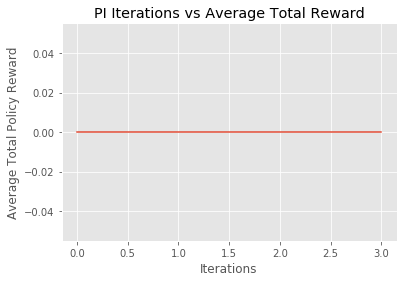

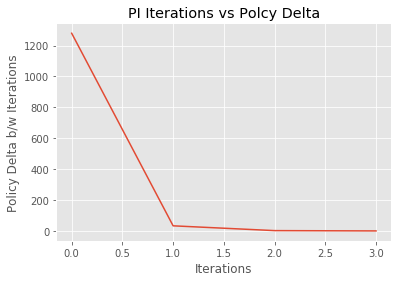

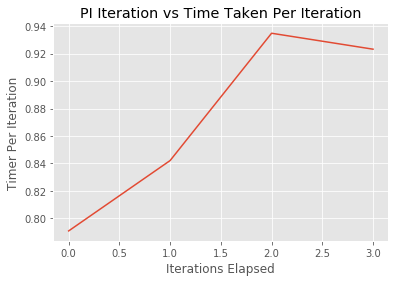

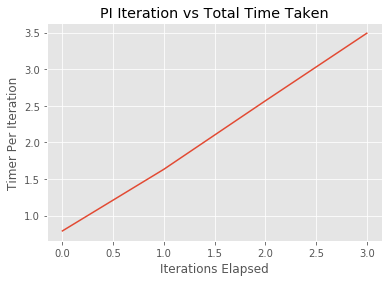

Gamma: 0.5
0
1
2
3
4
Policy-Iteration converged at step 5.
Average scores =  0.0


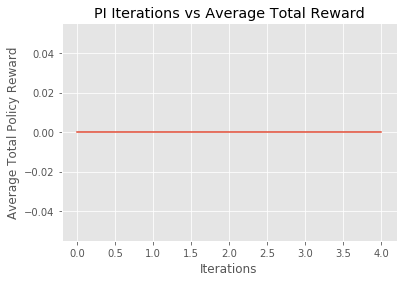

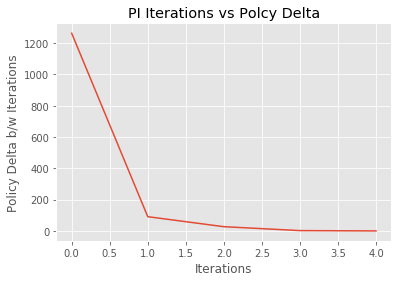

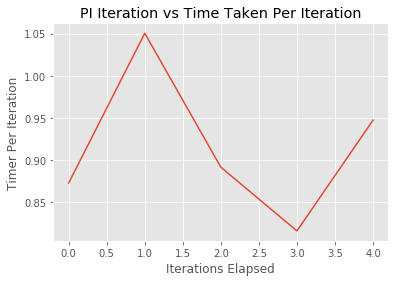

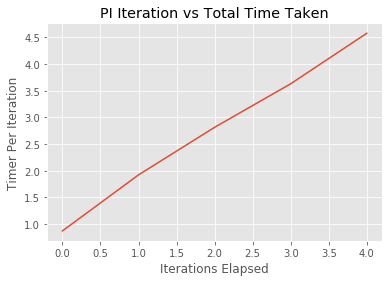

Gamma: 0.9
0
1
2
3
4
5
6
7
8
9
10
11
Policy-Iteration converged at step 12.
Average scores =  0.02


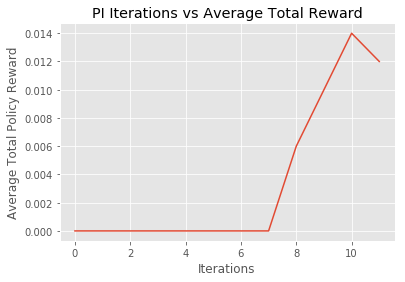

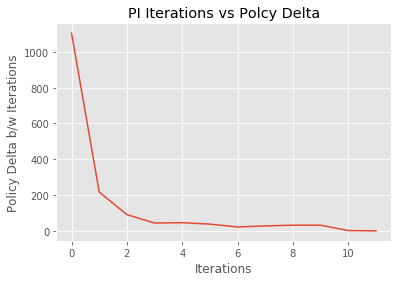

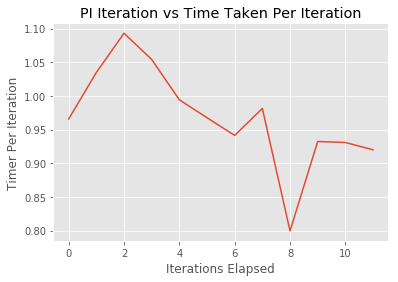

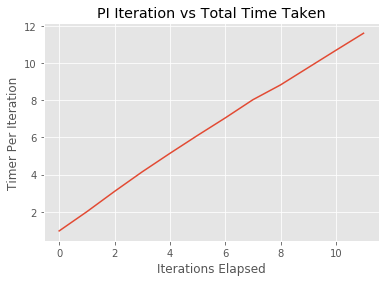

Gamma: 0.95
0
1
2
3
4
5
Policy-Iteration converged at step 6.
Average scores =  0.016


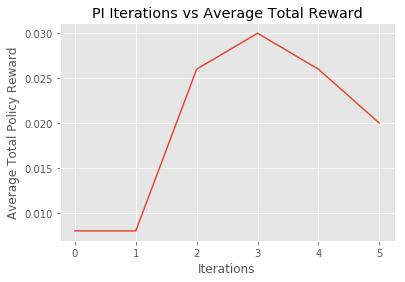

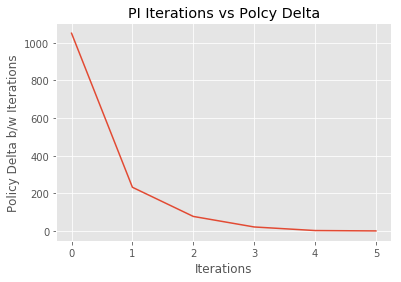

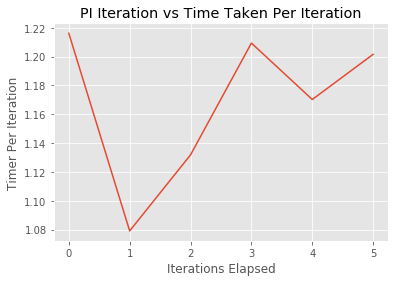

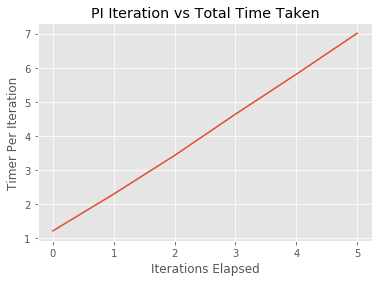

Gamma: 1.0
0
1
2
3
4
5
6
7
8
9
Policy-Iteration converged at step 10.
Average scores =  0.24


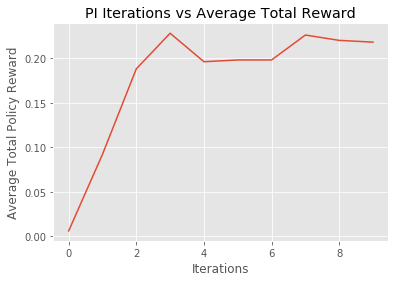

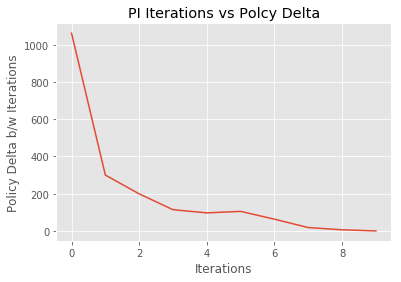

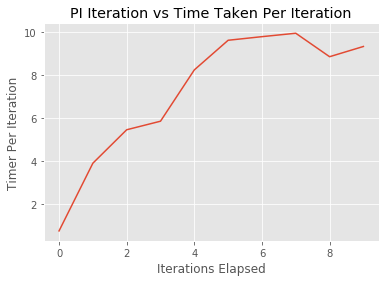

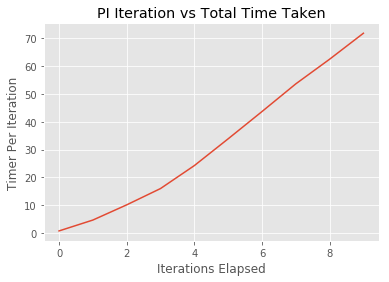

In [113]:
gamma_list = [0.1,0.3,0.5,0.9,0.95,1.0]
for g in gamma_list:
    print('Gamma: ' + str(g))
    env = fl.FrozenLakeEnv(desc=None, map_name="22x40",is_slippery=True)
    optimal_policy, policy_differences, iteration_rewards, iteration_time_differences, run_time_elapsed = policy_iteration(env, gamma = g)
    scores = evaluate_policy(env, optimal_policy, gamma = g)
    print('Average scores = ', np.mean(scores))

    iteration_rewards = pd.DataFrame(iteration_rewards, columns = ['Iteration','Average Total Policy Reward'])
    iteration_rewards.set_index('Iteration')
    plt.xlabel('Iterations')
    plt.ylabel('Average Total Policy Reward')
    plt.title('PI Iterations vs Average Total Reward')
    plt.plot(iteration_rewards['Iteration'],iteration_rewards['Average Total Policy Reward'])
    plt.show()

    plt.plot(policy_differences)
    plt.xlabel('Iterations')
    plt.ylabel('Policy Delta b/w Iterations')
    plt.title('PI Iterations vs Polcy Delta')
    plt.show()

    plt.plot(pd.DataFrame(iteration_time_differences))
    plt.xlabel('Iterations Elapsed')
    plt.ylabel('Timer Per Iteration')
    plt.title('PI Iteration vs Time Taken Per Iteration')
    plt.show()

    plt.plot(run_time_elapsed)
    plt.xlabel('Iterations Elapsed')
    plt.ylabel('Timer Per Iteration')
    plt.title('PI Iteration vs Total Time Taken')
    plt.show()

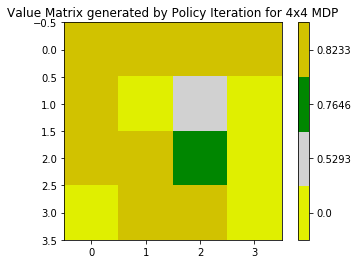

In [117]:
import matplotlib.pyplot as plt
import matplotlib.colors

a = v.reshape(4,4)
ca = v.reshape(4,4)

u, ind = np.unique(a, return_inverse=True)
b = ind.reshape((a.shape))

colors = a[a[:,0].argsort()][:,1:]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(np.arange(len(a)+1)-0.5, len(a))

plt.imshow(b, cmap=cmap, norm=norm)

cb = plt.colorbar(ticks=np.arange(len(a)))
cb.ax.set_yticklabels(np.unique(a).round(4))

plt.title('Value Matrix generated by Policy Iteration for 4x4 MDP')
plt.show()

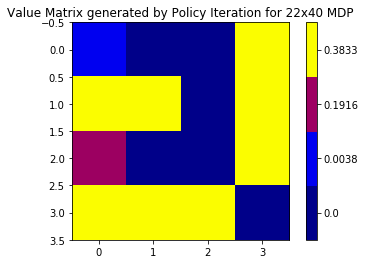

In [119]:
import matplotlib.pyplot as plt
import matplotlib.colors

a = v[864:880].reshape(4,4)
ca = v[864:880].reshape(4,4)

u, ind = np.unique(a, return_inverse=True)
b = ind.reshape((a.shape))

colors = a[a[:,0].argsort()][:,1:]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(np.arange(len(a)+1)-0.5, len(a))
plt.imshow(b, cmap=cmap, norm=norm)

cb = plt.colorbar(ticks=np.arange(len(a)))
cb.ax.set_yticklabels(np.unique(a).round(4))

plt.title('Value Matrix generated by Policy Iteration for 22x40 MDP')

plt.show()

# Reward Shaping

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


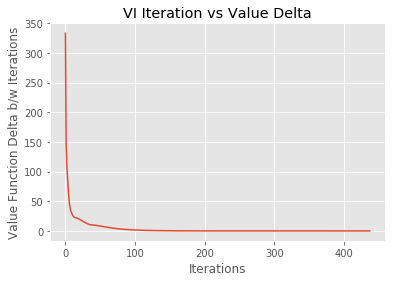

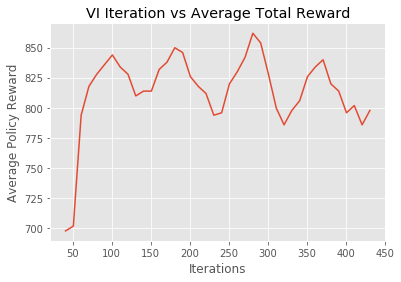

In [43]:
g = 1.0
env = fl_r.FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=True)
policy, v, value_differences, iteration_time_differences, run_time_elapsed, iteration_rewards = value_iteration(env, discount_factor = g)


print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.nrow*env.ncol))
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.ncol * env.nrow))
print("")

print('Iterations and Rewards of Final Policy')
print(iteration_rewards[-1])

plt.plot(value_differences)
plt.xlabel('Iterations')
plt.ylabel('Value Function Delta b/w Iterations')
plt.title('VI Iteration vs Value Delta')
plt.show()

iteration_rewards = pd.DataFrame(iteration_rewards, columns = ['Iteration','Average Total Policy Reward'])
iteration_rewards.set_index('Iteration')
plt.xlabel('Iterations')
plt.ylabel('Average Policy Reward')
plt.title('VI Iteration vs Average Total Reward')
plt.plot(iteration_rewards['Iteration'],iteration_rewards['Average Total Policy Reward'].rolling(5).mean())
plt.show()

239
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]

Reshaped Grid Value Function:
[0.61614626 0.61061645 0.60693753 0.60510048 0.61801383 0.
 0.03994281 0.         0.62174707 0.62735504 0.51301367 0.
 0.         0.74919336 0.87328488 0.        ]

Iterations and Rewards of Final Policy
[231, 0.6]


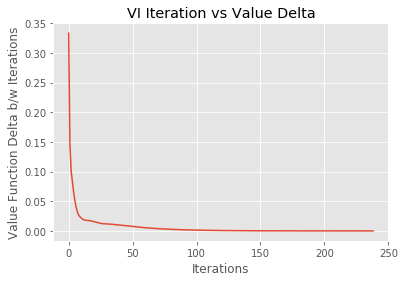

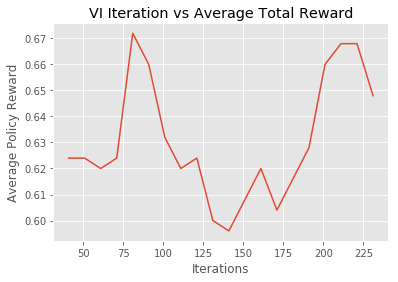

In [115]:
g = 1.0
env = fl_rv2.FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=True)
policy, v, value_differences, iteration_time_differences, run_time_elapsed, iteration_rewards = value_iteration(env, discount_factor = g)


print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.nrow*env.ncol))
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.ncol * env.nrow))
print("")

print('Iterations and Rewards of Final Policy')
print(iteration_rewards[-1])

plt.plot(value_differences)
plt.xlabel('Iterations')
plt.ylabel('Value Function Delta b/w Iterations')
plt.title('VI Iteration vs Value Delta')
plt.show()

iteration_rewards = pd.DataFrame(iteration_rewards, columns = ['Iteration','Average Total Policy Reward'])
iteration_rewards.set_index('Iteration')
plt.xlabel('Iterations')
plt.ylabel('Average Policy Reward')
plt.title('VI Iteration vs Average Total Reward')
plt.plot(iteration_rewards['Iteration'],iteration_rewards['Average Total Policy Reward'].rolling(5).mean())
plt.show()

In [ ]:
##doesnt converge do not run
g = 1.0
env = fl_r.FrozenLakeEnv(desc=None, map_name="22x40",is_slippery=True)
policy, v, value_differences, iteration_time_differences, run_time_elapsed, iteration_rewards = value_iteration(env, discount_factor = g)


print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.nrow*env.ncol))
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.ncol * env.nrow))
print("")

print('Iterations and Rewards of Final Policy')
print(iteration_rewards[-1])

plt.plot(value_differences)
plt.xlabel('Iterations')
plt.ylabel('Value Function Delta b/w Iterations')
plt.title('VI Iteration vs Value Delta')
plt.show()

iteration_rewards = pd.DataFrame(iteration_rewards, columns = ['Iteration','Average Total Policy Reward'])
iteration_rewards.set_index('Iteration')
plt.xlabel('Iterations')
plt.ylabel('Average Policy Reward')
plt.title('VI Iteration vs Average Total Reward')
plt.plot(iteration_rewards['Iteration'],iteration_rewards['Average Total Policy Reward'].rolling(5).mean())
plt.show()

In [ ]:
##doesnt converge do not run
g = 1.0
env = fl_rv2.FrozenLakeEnv(desc=None, map_name="22x40",is_slippery=True)
policy, v, value_differences, iteration_time_differences, run_time_elapsed, iteration_rewards = value_iteration(env, discount_factor = g)


print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.nrow*env.ncol))
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.ncol * env.nrow))
print("")

print('Iterations and Rewards of Final Policy')
print(iteration_rewards[-1])

plt.plot(value_differences)
plt.xlabel('Iterations')
plt.ylabel('Value Function Delta b/w Iterations')
plt.title('VI Iteration vs Value Delta')
plt.show()

iteration_rewards = pd.DataFrame(iteration_rewards, columns = ['Iteration','Average Total Policy Reward'])
iteration_rewards.set_index('Iteration')
plt.xlabel('Iterations')
plt.ylabel('Average Policy Reward')
plt.title('VI Iteration vs Average Total Reward')
plt.plot(iteration_rewards['Iteration'],iteration_rewards['Average Total Policy Reward'].rolling(5).mean())
plt.show()

# Impact of Hardness of MDP

In [46]:
#env = gym.make('FrozenLake-v0')
env = fl.FrozenLakeEnv(desc=None, map_name="4x4_EASY",is_slippery=True)
policy, v, value_differences, iteration_time_differences, run_time_elapsed, iteration_rewards = value_iteration(env
        , discount_factor = 1.0)

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.nrow*env.ncol))
print("Iteration Rewards and Convergence")
print(iteration_rewards[-1])
print("")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
112
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 0 0 0 0 0 0 0 3 1 0 0 0 0 2 0]
Iteration Rewards and Convergence
[111, 0.1]



In [47]:
#env = gym.make('FrozenLake-v0')
env = fl.FrozenLakeEnv(desc=None, map_name="22x40_EASY",is_slippery=True)
policy, v, value_differences, iteration_time_differences, run_time_elapsed, iteration_rewards = value_iteration(env
        , discount_factor = 1.0)

print("Iteration Rewards and Convergence")
print(iteration_rewards[-1])
print("")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [133]:
#env = gym.make('FrozenLake-v0')
env = fl_r.FrozenLakeEnv(desc=None, map_name="4x4_EASY",is_slippery=True)
policy, v, value_differences, iteration_time_differences, run_time_elapsed, iteration_rewards = value_iteration(env
        , discount_factor = 1.0)

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.nrow*env.ncol))
print("Iteration Rewards and Convergence")
print(iteration_rewards[-1])
print("")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
215
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[0 0 0 0 0 0 0 0 3 1 0 0 0 0 2 0]
Iteration Rewards and Convergence
[211, 79.08]



In [134]:
#env = gym.make('FrozenLake-v0')
env = fl_r.FrozenLakeEnv(desc=None, map_name="22x40_EASY",is_slippery=True)
policy, v, value_differences, iteration_time_differences, run_time_elapsed, iteration_rewards = value_iteration(env
        , discount_factor = 1.0)

print("Iteration Rewards and Convergence")
print(iteration_rewards[-1])
print("")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


# Policy iteration experiments

In [48]:
env = fl.FrozenLakeEnv(desc=None, map_name="22x40",is_slippery=True)
gamma =1.0
policy, policy_differences, iteration_rewards, iteration_time_differences, run_time_elapsed =  policy_iteration(env, gamma = 1.0)

0
1
2
3
4
5
6
7
8
9
Policy-Iteration converged at step 10.


In [49]:
print('Iterations to Convergence')
env = fl.FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=True)
policy, policy_differences, iteration_rewards, iteration_time_differences, run_time_elapsed =  policy_iteration(env, gamma = 1.0)

Iterations to Convergence
0
1
2
3
4
5
6
Policy-Iteration converged at step 7.


## Hardness

In [28]:
print('Iterations to Convergence')
env = fl.FrozenLakeEnv(desc=None, map_name="4x4_EASY",is_slippery=True)
policy, policy_differences, iteration_rewards, iteration_time_differences, run_time_elapsed =  policy_iteration(env, gamma = 1.0)

print('Iterations to Convergence')
env = fl.FrozenLakeEnv(desc=None, map_name="22x40_EASY",is_slippery=True)
policy, policy_differences, iteration_rewards, iteration_time_differences, run_time_elapsed =  policy_iteration(env, gamma = 1.0)

Iterations to Convergence
0
1
2
3
4
Policy-Iteration converged at step 5.
Iterations to Convergence
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Policy-Iteration converged at step 32.


# Rewards Shaping

In [ ]:
#doesn't converge do not run
print('Iterations to Convergence')
env = fl_r.FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=True)
policy, policy_differences, iteration_rewards, iteration_time_differences, run_time_elapsed =  policy_iteration(env, gamma = 1.0)

#doesn't converge do not run
print('Iterations to Convergence')
env = fl_r.FrozenLakeEnv(desc=None, map_name="22x40",is_slippery=True)
policy, policy_differences, iteration_rewards, iteration_time_differences, run_time_elapsed =  policy_iteration(env, gamma = 1.0)

In [23]:
print('Iterations to Convergence')
env = fl_rv2.FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=True)
policy, policy_differences, iteration_rewards, iteration_time_differences, run_time_elapsed =  policy_iteration(env, gamma = 1.0)

#doesn't converge do not run
print('Iterations to Convergence')
env = fl_rv2.FrozenLakeEnv(desc=None, map_name="22x40",is_slippery=True)
policy, policy_differences, iteration_rewards, iteration_time_differences, run_time_elapsed =  policy_iteration(env, gamma = 1.0)

Iterations to Convergence
0
1
Policy-Iteration converged at step 2.
